In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import time
from fuzzywuzzy import fuzz
import tkinter as tk 
from tkinter import filedialog 

In [2]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [3]:
def findPlateLoc(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    time.sleep(1)

    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) #Edge detection

    time.sleep(1)

    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]

    time.sleep(1)

    location = None

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 20, True)
        if len(approx) == 4:
            location = approx
            break

    return gray, location     

In [4]:
path_name = "C:/Users/ebayemi/Desktop/PlateDetection/res/"

def start_training():
    data = {}
    data['plates'] = []
    for i in range(1, 50):
        img = cv2.imread(path_name + 'testimage ({}).jpg'.format(i))
        
        gray, location = findPlateLoc(img)
        if location is not None :
            mask = np.zeros(gray.shape, np.uint8)
            new_image = cv2.drawContours(mask, [location], 0,255, -1)
            new_image = cv2.bitwise_and(img, img, mask=mask)

            (x,y) = np.where(mask==255)
            (x1, y1) = (np.min(x), np.min(y))
            (x2, y2) = (np.max(x), np.max(y))
            cropped_image = gray[x1:x2+1, y1:y2+1]

            reader = easyocr.Reader(['en'])
            result = reader.readtext(cropped_image)
            
            if not result:
                text = ""
            else:
                text = result[0][-2]

            numpyData = {"array": location}
            encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)
            
        else:
            text = ""
            encodedNumpyData = {"array": [[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]}
        
        data['plates'].append({
            'img_path': path_name + 'testimage ({}).jpg'.format(i),
            'plate_number': text,
            'location': encodedNumpyData
        })
        
    with open('data.txt', 'w') as outfile:
        json.dump(data, outfile)

In [5]:
start_training()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

In [6]:
user_input = input("Enter the plate number: \n")

Enter the plate number: 
BW 678RX


In [7]:
def showData():
    with open('data.txt') as json_file:
        data = json.load(json_file)
        for p in data['plates']:
            print(fuzz.ratio(user_input, p['plate_number']), p['plate_number'], p['img_path'], p['location'])

In [8]:
showData()

20 Z6 C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (1).jpg {"array": [[[215, 304]], [[224, 350]], [[432, 347]], [[426, 304]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (2).jpg {"array": [[[280, 44]], [[341, 52]], [[536, 198]], [[361, 50]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (3).jpg {'array': [[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (4).jpg {'array': [[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (5).jpg {'array': [[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (6).jpg {"array": [[[188, 170]], [[98, 188]], [[177, 196]], [[121, 179]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (7).jpg {'array': [[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]}
0  C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (8).jpg {"array": [[[146, 131]], [[176, 140]], [[144, 156]], [[190, 155]]]}
0

In [9]:
def upload_pic():
    print("Not Found in database :/")
    print("Import picture: ")
    root = tk.Tk() 
    root.withdraw() 
    pic_path = filedialog.askopenfilename() 
    return pic_path  
    

In [10]:
def show_prediction(ratio, car_path, location):
    print("Car is found in dataset!!!")
    print("Accuracy: " + str(ratio))
    img = cv2.imread(car_path)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    decodedArrays = json.loads(location)
    loc = np.asarray(decodedArrays["array"])
    
    res = cv2.putText(img, text=user_input, org=(loc[0][0][0], loc[1][0][1]+80), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(img, tuple(loc[0][0]), tuple(loc[2][0]), (0,255,0),3)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [11]:
def checkPic(car_path):
    print("Is this the one???")
    plt.imshow(cv2.imread(best_suits[0][1]))
    plt.show()
    reply = input('Type "yes" or "no"(y/n): ').lower()[0]
    return reply    

In [12]:
def update_db(user_input, car_path):
    img = img = cv2.imread(car_path)
    gray, location = findPlateLoc(img)
    
    numpyData = {"array": location}
    encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)
    
    with open('data.txt') as json_file:
        data = json.load(json_file)

        data['plates'].append({
                'img_path': car_path,
                'plate_number': user_input,
                'location': encodedNumpyData
            })
        
    with open('data.txt', 'w') as outfile:
        json.dump(data, outfile)
        
    print("Database updated!")

In [13]:
with open('data.txt') as json_file:
    data = json.load(json_file)
    best_suits = [[0, "", ""], [0, "", ""], [0, "", ""]]

    for p in data['plates']:
        cur = [fuzz.ratio(user_input, p['plate_number']), p['img_path'], p['location']]

        if cur[0] > best_suits[0][0]:
            temp = best_suits[0]
            best_suits[0] = cur
            cur = temp

        if cur[0] > best_suits[1][0]:
            temp = best_suits[1]
            best_suits[1] = cur
            cur = temp

        if cur[0] > best_suits[2][0]:
            best_suits[2] = cur

In [14]:
for best_suit in best_suits:
    print(best_suit)

[100, 'C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (11).jpg', '{"array": [[[223, 257]], [[414, 257]], [[415, 299]], [[226, 299]]]}']
[100, 'C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (42).jpg', '{"array": [[[223, 257]], [[414, 257]], [[415, 299]], [[226, 299]]]}']
[38, 'C:/Users/ebayemi/Desktop/PlateDetection/res/testimage (22).jpg', '{"array": [[[197, 258]], [[201, 306]], [[403, 308]], [[402, 258]]]}']


Car is found in dataset!!!
Accuracy: 100


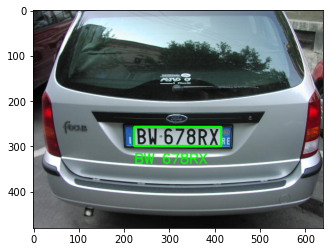

In [15]:
if best_suits[0][0] >= 90:
    show_prediction(best_suits[0][0], best_suits[0][1], best_suits[0][2])
    
elif best_suits[0][0] >=60 and best_suits[0][0] <90:
    reply = checkPic(best_suits[0][1])
    
    if reply == 'y':
        show_prediction(best_suits[0][0], best_suits[0][1], best_suits[0][2])
        
    elif reply == 'n':
        if best_suits[1][0] >=60 and best_suits[1][0] <90:
            reply = checkPic(best_suits[1][1])
            
            if reply == 'y':
                show_prediction(best_suits[1][0], best_suits[1][1], best_suits[1][2])
                
            elif reply == 'n':
                if best_suits[2][0] >=60 and best_suits[2][0] <90:
                    reply = checkPic(best_suits[2][1])
                    
                    if reply == 'y':
                        show_prediction(best_suits[2][0], best_suits[2][1], best_suits[2][2])
                        
                    elif reply == 'n':
                        new_pic_path = upload_pic()
                        update_db(user_input, new_pic_path)
                        showData()
                        
                    else:
                        print('Exited!!!')
                        
                else:
                    new_pic_path = load_pic()
                    update_db(user_input, new_pic_path)
                    showData()
                    
            else:
                print('Exited!!!')
                
        else:
            new_pic_path = load_pic()
            update_db(user_input, new_pic_path)
            showData()

    else:
        print('Exited!!!')    

else:
    new_pic_path = upload_pic()
    update_db(user_input, new_pic_path)
    showData()